In [1]:
# a bit of setup, as usual
import psycopg2 as ps
import psycopg2.extras as e

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

from itertools import product

# Visualization
First, let's connect to the Census dataset and plot some examples visualizations (views)

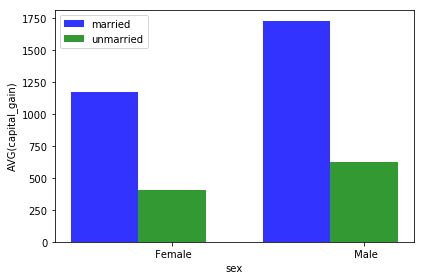

CPU times: user 342 ms, sys: 67.3 ms, total: 410 ms
Wall time: 791 ms


In [2]:
%%time

# connect to Census database
con = ps.connect("dbname='seedb' user='dthai' host='localhost' password=''")
cur = con.cursor()

# create view 
query = """create view married as 
                   select * from census where marital_status in (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent',' Separated');
               create view unmarried as 
                   select * from census where marital_status in (' Never-married', ' Widowed',' Divorced');"""
cur.execute(query)
con.commit()

# capital gain group-by sex for the target data (married)
query = "SELECT sex, avg(capital_gain) FROM married GROUP BY sex;"
cur.execute(query)
target_rows = cur.fetchall()

# capital gain group-by sex for the reference data (unmarried)
query = "SELECT sex, avg(capital_gain) FROM unmarried GROUP BY sex;"
cur.execute(query)
ref_rows = cur.fetchall()

# util function to plot the view 
def visualize(target_data, ref_data, view_tuple):
    n_groups = len(target_data)
    group_by, measure, function = view_tuple

    means_target = target_data.values()
    means_ref = ref_data.values()

    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(index, means_target, bar_width,
                     alpha=opacity,
                     color='b',
                     label='married')

    rects2 = plt.bar(index + bar_width, means_ref, bar_width,
                     alpha=opacity,
                     color='g',
                     label='unmarried')

    plt.xlabel('{}'.format(group_by))
    plt.ylabel('{}({})'.format(function, measure))
    plt.xticks(index + bar_width, target_data.keys())
    plt.legend()

    plt.tight_layout()
    plt.show()

# visualize it!
view_tuple = ('sex', 'capital_gain', 'AVG')
visualize(dict(target_rows), dict(ref_rows), view_tuple)

# The phased-execution framework

We partition the Census dataset into 5 parts, corresponding to 5 phases. For each partitition, we create views for target (married) and reference (unmarried).

In [3]:
n_phases = 5

for i in range(n_phases):
    query = """create view s{}_married as 
                   select * from split{} where marital_status in (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent',' Separated');
               create view s{}_unmarried as 
                   select * from split{} where marital_status in (' Never-married', ' Widowed',' Divorced');""".format(i+1,i+1,i+1,i+1)
    cur.execute(query)
    con.commit()

## Sharing-based Optimizations

In [31]:
functions = ["avg", "sum", "min", "max", "count"]
attributes = ["workclass", "education", "occupation", "relationship", "race", "sex", "native_country", "economic_indicator"]
measurements = ["age", "fnlwgt", "hours_per_week", "capital_gain", "capital_loss"]

views = {k: v for k,v in enumerate(list(product(functions, measurements, attributes)))}
print('Total number of visualizations: {}.'.format(len(views)))

Total number of visualizations: 200.


In [122]:
%%time

def sharing_based_query(views, tables):
    # combine multiple aggregates and multiple group-by
    select_a_str = []
    select_m_str = []
    group_by_str = []
    for i, (f, m, a) in views.items():
        select_a_str.append('{}'.format(a))
        select_m_str.append('{}({}) as v{}'.format(f, m, i))
        group_by_str.append('({})'.format(a))

    select_a_str = ', '.join(set(select_a_str))
    select_m_str = ', '.join(select_m_str)
    group_by_str = ', '.join(set(group_by_str))

    data = []
    for table in tables:
        query = """select {}, {} from {} group by grouping sets ({});""".format(select_a_str, select_m_str, table, group_by_str)
        cur.execute(query)
        data.append(cur.fetchall())
    cols = [desc[0] for desc in cur.description]
    return data, cols

tables = ['married', 'unmarried']
data, cols = sharing_based_query(views, tables)

CPU times: user 11.6 ms, sys: 2.35 ms, total: 14 ms
Wall time: 1.96 s


In [131]:
%%time

# different types of distribution w.r.t. the aggregate functions
distribution2type = {'count': 'multinomial', 'sum': 'gaussian', 'avg': 'gaussian', 'min': 'gumbel', 'max': 'gumbel'}

def multinomial_kl(tgt, ref):
    return -np.sum([qi * np.log(pi/qi) for qi, pi in zip(tgt, ref)])

def gaussian_kl(tgt, ref):
    pass

def gumble_kl(tgt, ref):
    pass

# KL-Divergence(target, reference)
def kl_divergence(target_df, reference_df, distribution_type):
    tgt = target_df.values.reshape(-1)
    ref = reference_df.values.reshape(-1)
    
    if distribution_type == 'multinomial':
        tgt_prob = tgt / np.sum(tgt)
        ref_prob = ref / np.sum(ref)
        return multinomial_kl(tgt_prob, ref_prob)
    return None

for i in range(n_phases):
    tables = ['s{}_married'.format(i+1), 's{}_unmarried'.format(i+1)]
    data, cols = sharing_based_query(views, tables)
    
    tgt_df = pd.DataFrame(data[0], columns=cols)
    ref_df = pd.DataFrame(data[1], columns=cols)
    
    for i, (f, m, a) in views.items():
        tgt = tgt_df.loc[tgt_df[a].notnull(), ['v{}'.format(i)]]
        ref = ref_df.loc[ref_df[a].notnull(), ['v{}'.format(i)]]
        
        score = kl_divergence(tgt, ref, distribution2type[f])
        if score is not None:
            print(i, f, m, a, score)
            break

160 count age workclass 2.78193805489
160 count age workclass 0.546491980922
160 count age workclass 0.577855079248
160 count age workclass 0.0623353958171
160 count age workclass 0.0778762412213
CPU times: user 2.42 s, sys: 57.9 ms, total: 2.47 s
Wall time: 2.79 s


In [126]:
tgt_df = pd.DataFrame(data[0], columns=cols)
ref_df = pd.DataFrame(data[1], columns=cols)
    
i, f, m, a = 160, 'count', 'age', 'workclass'
tgt = tgt_df.loc[tgt_df[a].notnull(), ['v{}'.format(i)]]
ref = ref_df.loc[ref_df[a].notnull(), ['v{}'.format(i)]]